In [12]:
import matplotlib
import matplotlib.pyplot as plt
import gzip, pickle
import seaborn as sn
import pandas as pd
import riem_funcs
from riem_funcs import *
import scipy.linalg as linalg

In [2]:
matplotlib.__version__

'3.3.2'

## Create result directories

In [3]:
try:
    os.mkdir('RiemannResults')
except FileExistsError:
    pass

In [4]:
data_dir = 'data'+os.sep

## Pull the data and metadata files

In [5]:
meta_dir = 'metadata'+os.sep
valid_runs_uiuc = pd.read_csv(meta_dir + 'UIUC_valid_runs.csv',index_col='ID',header=0,names=['ID','A','B','C','D','E','F','G'],usecols=['ID','A','B'])
valid_runs_whasc = pd.read_csv(meta_dir + 'WHASC_valid_runs.csv',index_col='ID',header=0,names=['ID','A','B','C','D'],usecols=['ID','A','B'])

valid_runs_dict_uiuc = {re.sub(r'\d+_','',idx.rstrip('*')): row.values for idx,row in valid_runs_uiuc.iterrows()}
valid_runs_dict_whasc = {re.sub(r'\d+_','',idx.rstrip('*')): row.values for idx,row in valid_runs_whasc.iterrows()}

metadata_uiuc = pd.read_csv(meta_dir + 'UIUC_metadata.csv',index_col = 'ID')
metadata_whasc = pd.read_csv(meta_dir + 'WHASC_metadata.csv',index_col = 'ID')

uiuc_files = [data_dir+'UIUC'+os.sep+fname for fname in os.listdir(data_dir+'UIUC') if not fname.startswith('.')]
whasc_files = [data_dir+'WHASC'+os.sep+fname for fname in os.listdir(data_dir+'WHASC') if not fname.startswith('.')]

## Annotate each time series with the appropriate labels

In [6]:
uiuc_samples = []
count =0
for fname_prefix in uiuc_files:
    runs = [run for run in os.listdir(fname_prefix) if run.startswith('run')]
    for run in runs:
        count += 1
        ID = re.findall(r'\d+_(\d+)_',fname_prefix)[0]
        Group_binary = re.findall(r'(\d+)_\d+_',fname_prefix)[0][1:]
        if Group_binary == "00":
            Group = 'ctr'
        if Group_binary == "01":
            Group = 'hl'
        if Group_binary == "10":
            Group = 'tin'
        if Group_binary == "11":
            Group = 'tin_hl'
        
        filename = "ROI_matrix_data_33.csv"
        try:
            timeSeries = np.genfromtxt(fname_prefix+os.sep+run+os.sep+filename,delimiter=',')
        except OSError:
            continue
            
        if timeSeries.shape == (33,300):
            uiuc_samples.append({'TimeSeries':timeSeries,'Location':'chm','Run':run,'ID':ID,'Group':Group})          

C:\Users\danie\anaconda3\envs\Neuro\lib\site-packages\ipykernel_launcher.py:20: UserWarning: genfromtxt: Empty input file: "data\UIUC\Fh_001_285_B\run5\ROI_matrix_data_33.csv"


In [7]:
whasc_samples = []
for fname_prefix in whasc_files:
    runs = [run for run in os.listdir(fname_prefix) if run.startswith('run')]
    for run in runs:
        ID = re.findall(r'\d+_(\d+)_',fname_prefix)[0]
        Group_binary = re.findall(r'(\d+)_\d+_',fname_prefix)[0][1:]
        if Group_binary == "00":
            Group = 'ctr'
        if Group_binary == "01":
            Group = 'hl'
        if Group_binary == "10":
            Group = 'tin'
        if Group_binary == "11":
            Group = 'tin_hl'
        filename = "ROI_matrix_data_33.csv"
        timeSeries = np.genfromtxt(fname_prefix+os.sep+run+os.sep+filename,delimiter=',')
        
        whasc_samples.append({'TimeSeries':timeSeries,'Location':'san','Run':run,'ID':ID,'Group':Group})

## Visualize the data before and after the tangent space projection

In [8]:
data = {'samples':uiuc_samples+whasc_samples}
X = np.array([sample['TimeSeries'] for sample in data['samples']]) #if data_selector(sample,valid_runs_dict_uiuc,valid_runs_dict_whasc)])  
y = np.array([get_label_8(sample['Group'],sample['Location']) for sample in data['samples']])# if data_selector(sample,valid_runs_dict_uiuc,valid_runs_dict_whasc)])
covest = Covariances()
ts = TangentSpace()
to_mat= to_symm_mat(0,33)
transformer = make_pipeline(covest,ts,to_mat)
covs = covest.fit_transform(X)
transformed = transformer.fit_transform(X)

class_indices = [[ind for ind,x in enumerate(y) if x == j] for j in range(0,8)]
class_list = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','hl_tin_chm','hl_tin_san','tin_chm','tin_san']

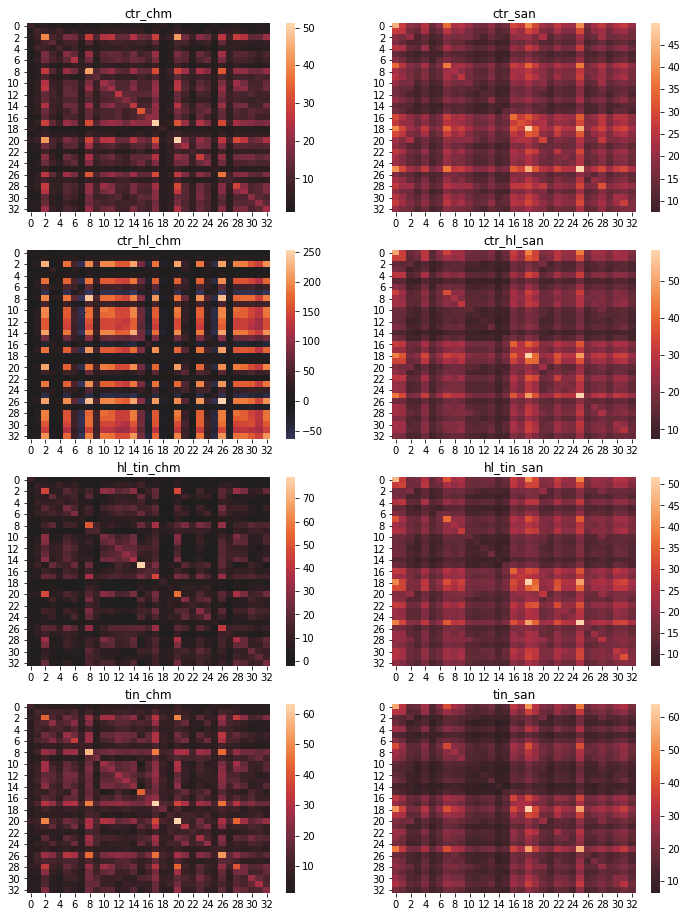

In [9]:
fig,axs = plt.subplots(4,2,figsize=(12,16))
for cls,ind_list in enumerate(class_indices):
    mean = np.mean([covs[i] for i in ind_list],axis=0)
    axs[cls//2,cls%2].set_title(class_list[cls])
    sn.heatmap(mean,center=0,ax=axs[cls//2,cls%2])
plt.savefig('RiemannResults/AvgCovMat.png',bbox_inches='tight')

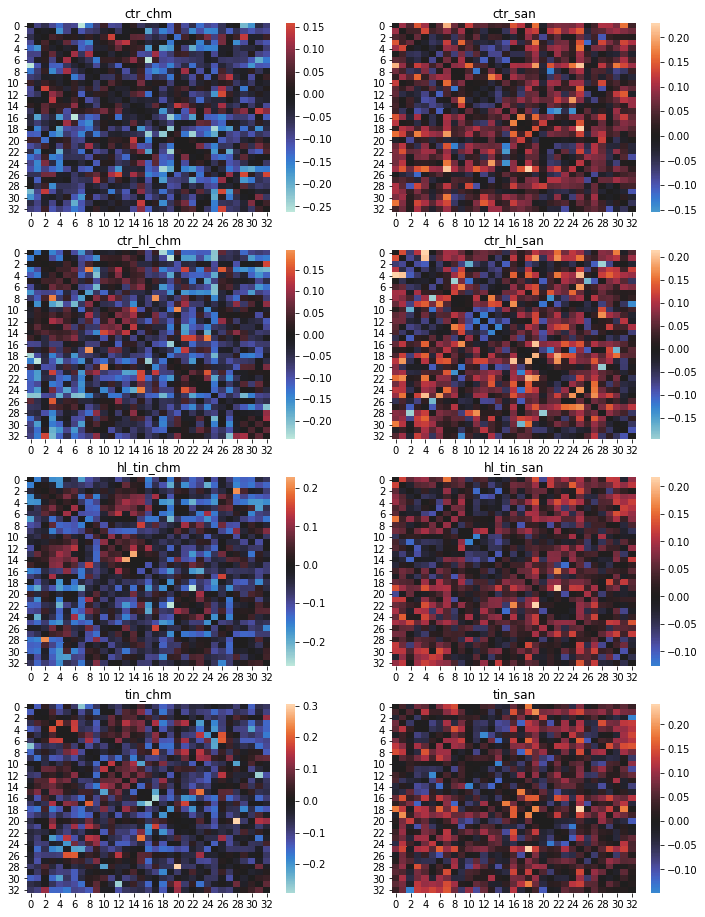

In [10]:
fig,axs = plt.subplots(4,2,figsize=(12,16))
for cls,ind_list in enumerate(class_indices):
    mean = np.mean([transformed[i] for i in ind_list],axis=0)
    axs[cls//2,cls%2].set_title(class_list[cls])
    sn.heatmap(mean-(mean*np.eye(mean.shape[0])),center=0,ax=axs[cls//2,cls%2])
plt.savefig('RiemannResults/AvgCovMatRiem.png',bbox_inches='tight')

### Use condition number to estimate collinearity before and after projection

In [84]:
X_cov = np.array([x[np.triu_indices(33,k=1)] for x in covs])
X_riem = np.array([x[np.triu_indices(33,k=1)] for x in transformed])
Z_cov = (X_cov - np.mean(X_cov, axis=0)) / np.std(X_cov, axis=0)
Z_riem = (X_riem - np.mean(X_riem, axis=0)) / np.std(X_riem, axis=0)

In [85]:
X_cov.shape

(574, 528)

In [87]:
print("Condition number before projection: " + str(np.linalg.cond(Z_cov.T @ Z_cov)))
print("Condition number after projection: " + str(np.linalg.cond(Z_riem.T @ Z_riem)))

Condition number before projection: 2.107346269653589e+18
Condition number after projection: 1.5744539340424146e+18


### Plot largest eigenvalues to see what kind of distribution they have before and after transition.

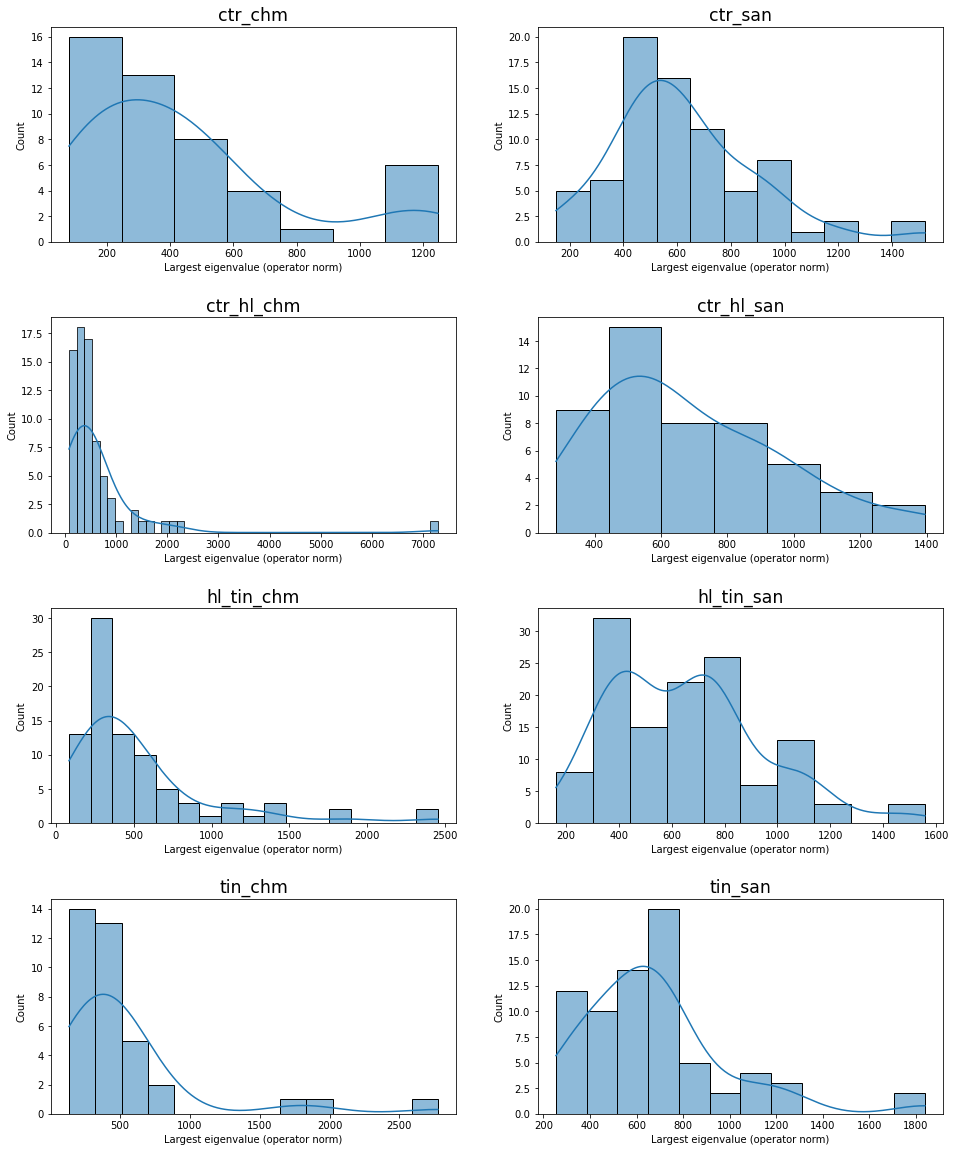

In [88]:
#before transition
fig,axs = plt.subplots(4,2,figsize=(16,20))
plt.subplots_adjust(hspace=0.35)
for cls,ind_list in enumerate(class_indices):
    #evals are 0-indexed
    which_eval = 0
    largest_evals = [linalg.eig(covs[i])[0][which_eval].real for i in ind_list if linalg.eig(covs[i])[0][0].real < 100000]
    axs[cls//2,cls%2].set_title(class_list[cls],fontsize='xx-large')
    sn.histplot(largest_evals,kde=True,ax=axs[cls//2,cls%2])
    #axs[cls//2,cls%2].set_xlim(0,2500)
    #axs[cls//2,cls%2].set_ylim(0,35)
    axs[cls//2,cls%2].set_xlabel('Largest eigenvalue (operator norm)')
plt.savefig('RiemannResults\\histcovs' + str(which_eval) + '.png',bbox_inches='tight')

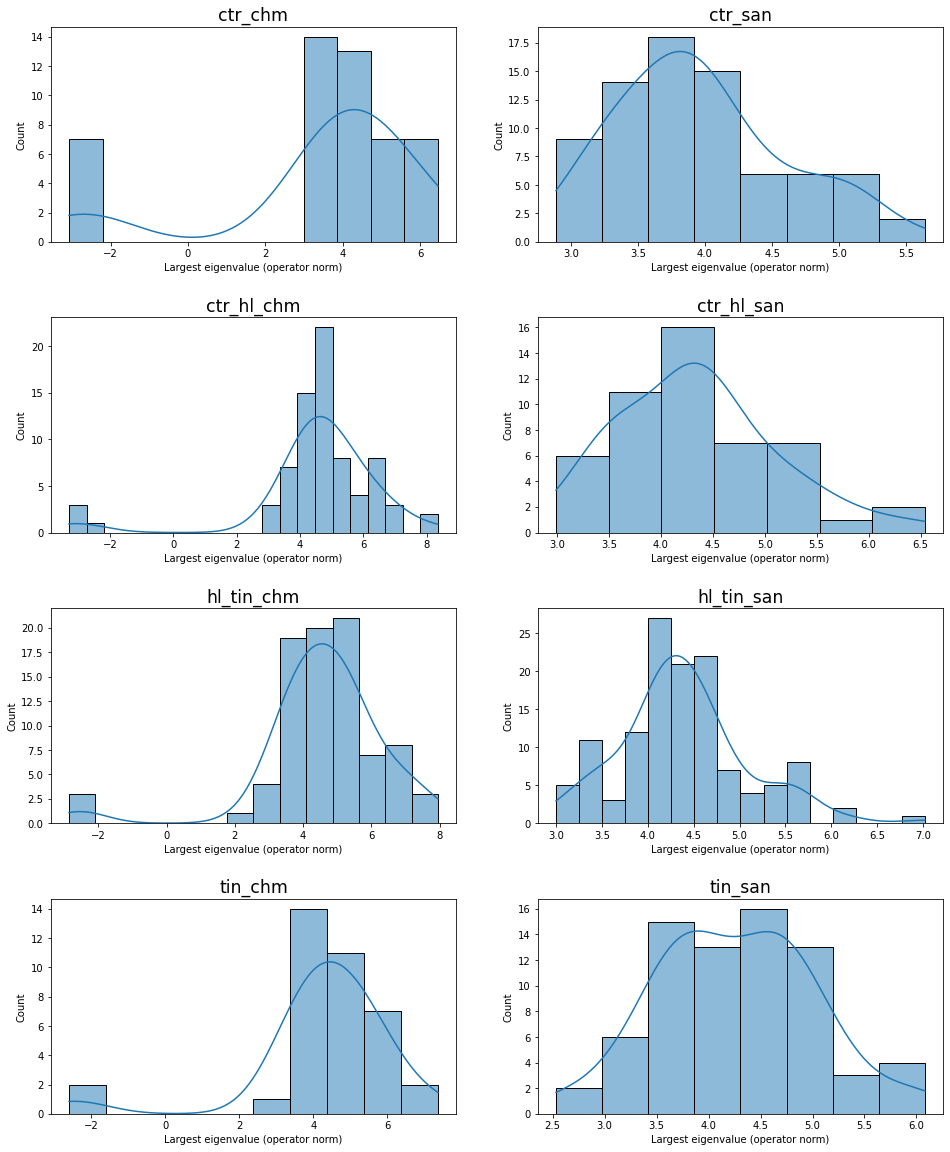

In [89]:
#After transition
fig,axs = plt.subplots(4,2,figsize=(16,20))
plt.subplots_adjust(hspace=0.35)
for cls,ind_list in enumerate(class_indices):
    #evals are 0-indexed
    which_eval = 0
    largest_evals = [linalg.eig(transformed[i])[0][which_eval].real for i in ind_list if linalg.eig(covs[i])[0][0].real < 100000]
    axs[cls//2,cls%2].set_title(class_list[cls],fontsize='xx-large')
    sn.histplot(largest_evals,kde=True,ax=axs[cls//2,cls%2])
    #axs[cls//2,cls%2].set_xlim(-4,10)
    #axs[cls//2,cls%2].set_ylim(0,30)
    axs[cls//2,cls%2].set_xlabel('Largest eigenvalue (operator norm)')
plt.savefig('RiemannResults\\histtransf' + str(which_eval) + '.png',bbox_inches='tight')

In [90]:
from pyriemann.utils.base import invsqrtm

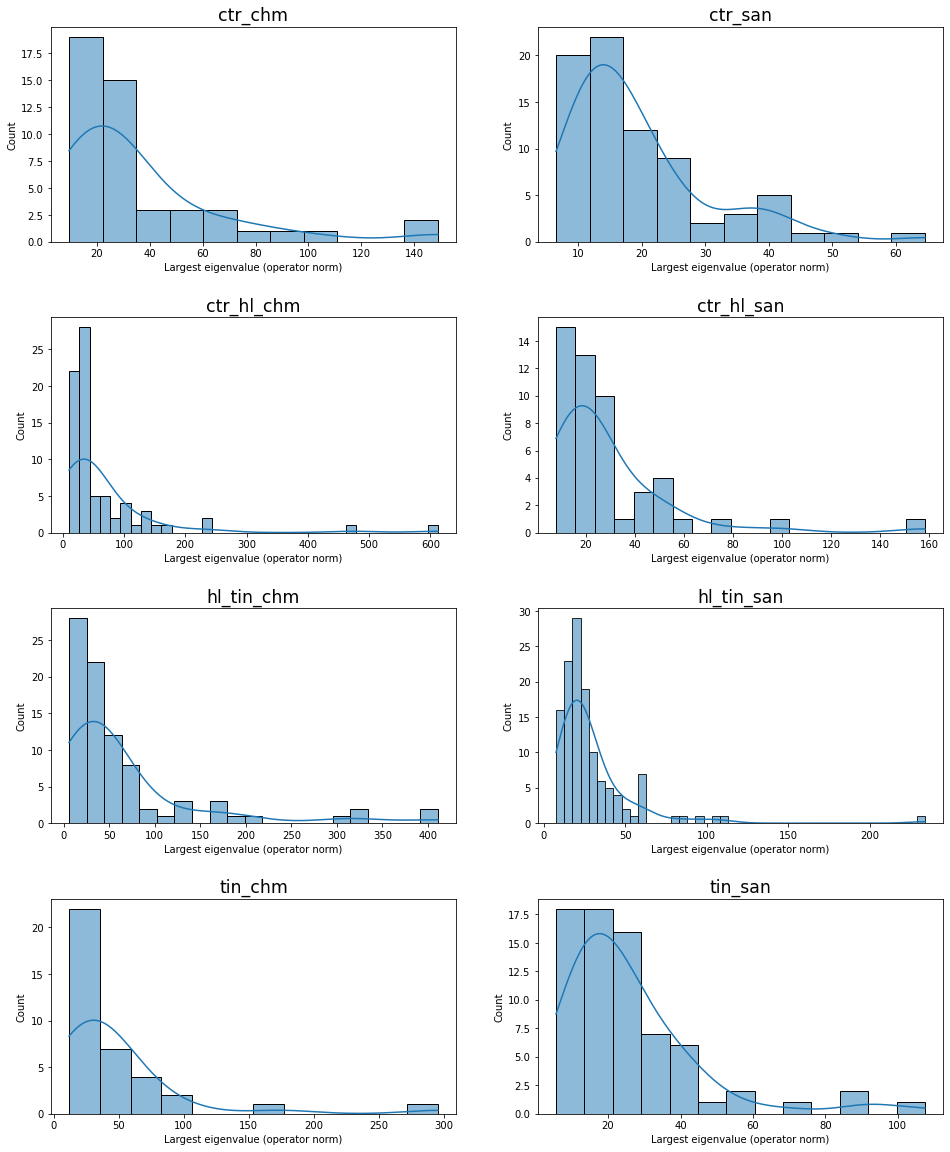

In [91]:
#Demeaned (half transition)
fig,axs = plt.subplots(4,2,figsize=(16,20))
plt.subplots_adjust(hspace=0.35)
frechet_mean = transformer[1].reference_
sqrtinv = invsqrtm(frechet_mean)
demeaned = [sqrtinv @ cov @ sqrtinv for cov in covs]
for cls,ind_list in enumerate(class_indices):
    #evals are 0-indexed
    which_eval = 0
    largest_evals = [linalg.eig(demeaned[i])[0][which_eval].real for i in ind_list
                     if linalg.eig(demeaned[i])[0][which_eval].real < 15000]
    axs[cls//2,cls%2].set_title(class_list[cls],fontsize='xx-large')
    sn.histplot(largest_evals,kde=True,ax=axs[cls//2,cls%2])
    #axs[cls//2,cls%2].set_xlim(0,2500)
    #axs[cls//2,cls%2].set_ylim(0,35)
    axs[cls//2,cls%2].set_xlabel('Largest eigenvalue (operator norm)')
plt.savefig('RiemannResults\\histcovsdem' + str(which_eval) + '.png',bbox_inches='tight')

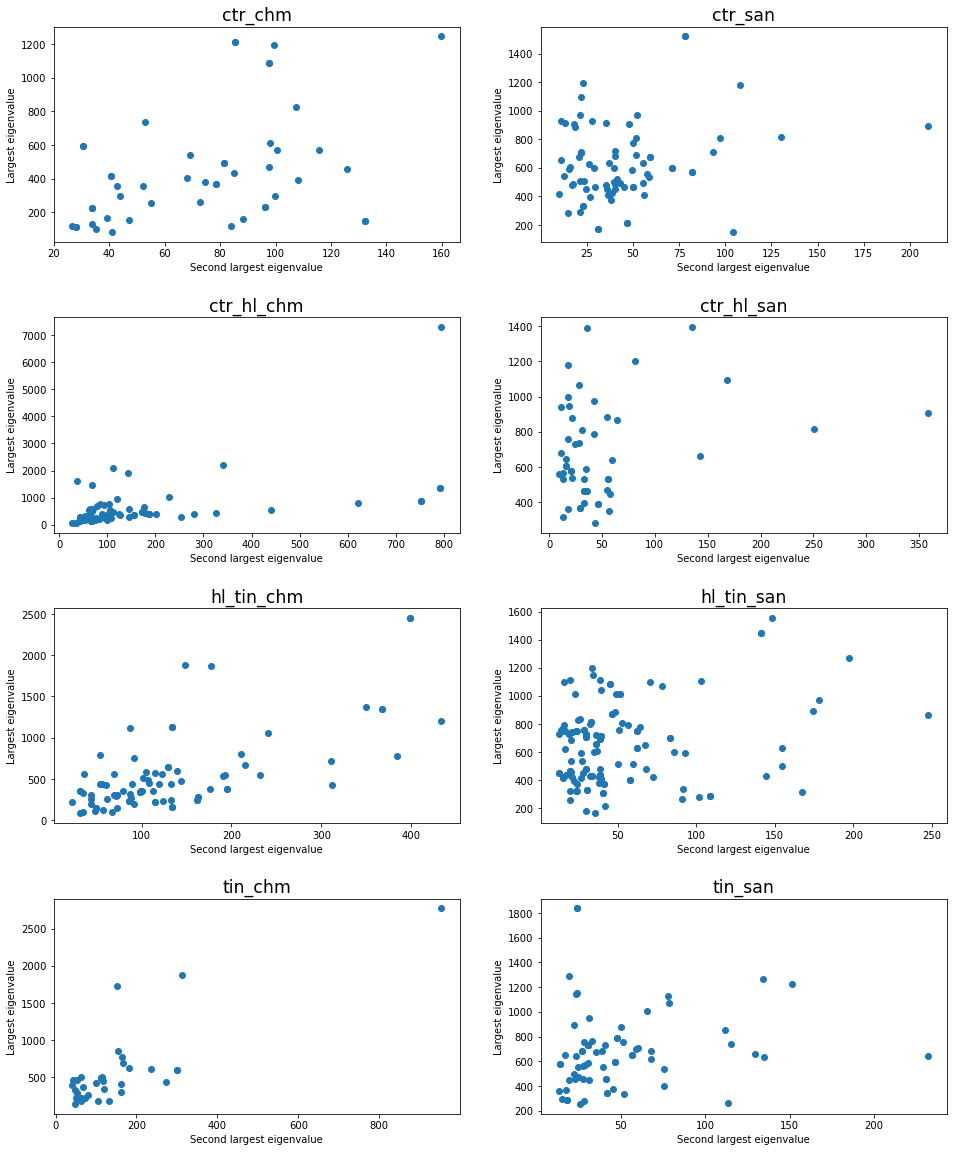

In [93]:
#largest vs second largest
fig,axs = plt.subplots(4,2,figsize=(16,20))
plt.subplots_adjust(hspace=0.35)
for cls,ind_list in enumerate(class_indices):
    #evals are 0-indexed
    which_eval = 0
    largest = []
    second_largest = []
    for i in ind_list:
        evals = linalg.eig(covs[i])[0]
        if evals[0].real < 100000:
            largest.append(evals[0].real)
            second_largest.append(evals[1].real)
    axs[cls//2,cls%2].set_title(class_list[cls],fontsize='xx-large')
    axs[cls//2,cls%2].scatter(second_largest,largest)
    #axs[cls//2,cls%2].set_xlim(0,2500)
    #axs[cls//2,cls%2].set_ylim(0,35)
    axs[cls//2,cls%2].set_xlabel('Second largest eigenvalue')
    axs[cls//2,cls%2].set_ylabel('Largest eigenvalue')
plt.savefig('RiemannResults\\compare_largest_evals_covs.png',bbox_inches='tight')

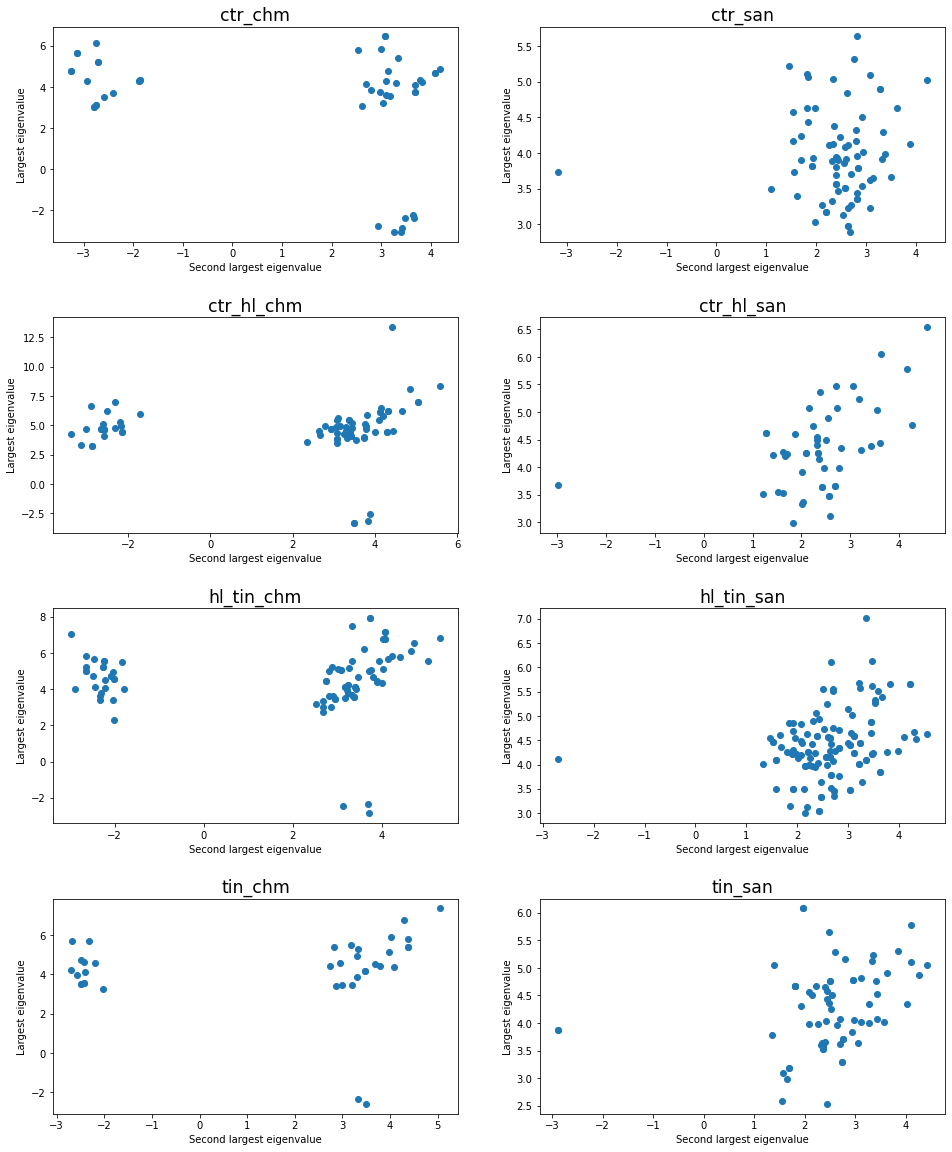

In [94]:
#largest vs second largest
fig,axs = plt.subplots(4,2,figsize=(16,20))
plt.subplots_adjust(hspace=0.35)
for cls,ind_list in enumerate(class_indices):
    #evals are 0-indexed
    which_eval = 0
    largest = []
    second_largest = []
    for i in ind_list:
        evals = linalg.eig(transformed[i])[0]
        if evals[0].real < 100000:
            largest.append(evals[0].real)
            second_largest.append(evals[1].real)
    axs[cls//2,cls%2].set_title(class_list[cls],fontsize='xx-large')
    axs[cls//2,cls%2].scatter(second_largest,largest)
    #axs[cls//2,cls%2].set_xlim(0,2500)
    #axs[cls//2,cls%2].set_ylim(0,35)
    axs[cls//2,cls%2].set_xlabel('Second largest eigenvalue')
    axs[cls//2,cls%2].set_ylabel('Largest eigenvalue')
plt.savefig('RiemannResults\\compare_largest_evals_riem.png',bbox_inches='tight')

In [73]:
train_classifiers.__doc__

"\n    Produces test data and tests whether projecting matrices into the tangent space finds the correct discriminative connection.\n    \n        Parameters:\n            data_files (list of pairs (filename,data)): the input data\n            valid_runs_dict_uiuc (dictionary): dictionary containing valid runs for each patient\n            valid_runs_dict_whasc (dictionary): dictionary containing valid runs for each patient\n            \n        Returns:\n            accDict (dictionary): mean accuracy on each file's data\n            simDict (dictionary): mean cosine similarity of classifier coefficients for each file\n            matDict (dictionary): mean confusion matrix for each file\n            corrDict (dictionary): before and after projection correlations\n            spearDict (dictionary): before and after projection spearman correlations\n    "

In [36]:
dicts = train_classifiers([['raw_data',{'samples':uiuc_samples+whasc_samples}]],valid_runs_dict_uiuc,valid_runs_dict_whasc)

Mean Accuracy w/ Riemann on data raw_data: 0.9139884393063583
Mean Accuracy w/ Cov on data raw_data: 0.6398265895953756
Mean Accuracy w/ RF on data raw_data: 0.7117919075144509
----------------


In [39]:
accDict, corrDict, spearDict, matDict, simDict = dicts

In [40]:
corrDict

{'raw_data': {'before': 446.2823509712932, 'after': 71.87607574495823}}

In [41]:
spearDict

{'raw_data': {'before': 447.0473941539398, 'after': 248.22121010065158}}

In [42]:
simDict

{'raw_data': [0.9529979798594266,
  0.8771167613088663,
  0.9560948232181055,
  0.9055569266385757,
  0.944995897150653,
  0.8840314737783141,
  0.9449813414453772,
  0.9485199847792216,
  0.8442032466470596,
  0.9433843957857897,
  0.8498499548704863,
  0.9412927821673414,
  0.8259650378269029,
  0.9531380685898633,
  0.8807980112738109,
  0.9330881846846686,
  0.8890010943691177,
  0.9393259307605313,
  0.9474366106314878,
  0.8579678570829955,
  0.9509431564910534,
  0.8526191692279992,
  0.9352396462002853,
  0.8822492116937501,
  0.9317882776453116,
  0.9401109747534229,
  0.8284357656238893,
  0.9363896272058881]}

In [ ]:
y_pred

In [ ]:
plt.figure()
df_cm = pd.DataFrame(mat, index = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','hl_tin_chm','hl_tin_san','tin_chm','tin_san'],
                      columns = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','hl_tin_chm','hl_tin_san','tin_chm','tin_san'])

sn.heatmap(df_cm, annot=True)
plt.title(fname + " average confusion matrix")
plt.ylabel('actual label')
plt.xlabel('predicted label')
plt.savefig('RiemannResults/'+'new_data'+'/AvgConfMat8class.png',bbox_inches='tight')

### Divide by sum along rows to normalize by total predictions in a given class 

In [ ]:
plt.figure()
df_cm = pd.DataFrame(mat/np.sum(mat,axis=0), index = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','hl_tin_chm','hl_tin_san','tin_chm','tin_san'],
                  columns = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','hl_tin_chm','hl_tin_san','tin_chm','tin_san'])

sn.heatmap(df_cm, annot=True)
plt.title(fname + " Pr(actual label | predicted label)")
plt.ylabel('actual label')
plt.xlabel('predicted label')
plt.savefig('RiemannResults/'+'new_data'+'/ConditionalAvgConfMat8Class.png',bbox_inches='tight')

### Get discriminative connections

In [ ]:
data = {'samples':uiuc_samples+whasc_samples}
# First, make null model
# Use integer labeling so we can be sure that the one vs one classifiers are 
# in the correct orders
X = np.array([sample['TimeSeries'] for sample in data['samples'] if data_selector(sample)])        
y = np.array([get_label_8(sample['Group'],sample['Location']) for sample in data['samples'] if data_selector(sample)])
# Randomly permute labels (only labels, not training input)

NUM_BOOTSTRAP = 10
covest = Covariances()
ts = TangentSpace()
sym_mat = to_symm_mat(0,33)
ut = to_upper_tri(1)
svc = SVC(kernel='linear')
clf_riem = make_pipeline(covest,ts,sym_mat,ut,svc)
maxcoeffs = []   
mincoeffs = []
nullcoeffs = []
nullcos = []
for i in range(0,100):
    y_permuted = np.random.permutation(y)
    coeffArr = []
    rs = ShuffleSplit(n_splits=NUM_BOOTSTRAP, test_size=.3)
    for train,test in rs.split(X):
        X_train, X_test, y_train, y_test = X[train],X[test],y_permuted[train],y_permuted[test]
        clf_riem.fit(X_train,y_train)
        coeffArr.append(clf_riem[4].coef_/np.std(clf_riem[4].coef_,axis=-1).reshape(28,1))
        
    meancoeff = sum(coeffArr)/len(coeffArr)
    classcos = []
    for z in range(0,len(coeffArr[0])):
        class_z_coeffs = [x[z] for x in coeffArr]
        cos_sim = cosine_similarity(class_z_coeffs)
        upperTri = cos_sim[np.triu_indices(cos_sim.shape[0],1)]
        cos_max = np.max(upperTri.flatten())
        classcos.append(cos_max)
        
    nullcos.append(classcos)
    nullcoeffs.append(meancoeff)
    maxcoeff = np.max(meancoeff,axis=-1)
    mincoeff = np.min(meancoeff,axis=-1)
    maxcoeffs.append(maxcoeff)
    mincoeffs.append(mincoeff)
    
coeffArr = []
rs = ShuffleSplit(n_splits=NUM_BOOTSTRAP, test_size=.3)
for train,test in rs.split(X):
    X_train, X_test, y_train, y_test = X[train],X[test],y[train],y[test]
    clf_riem.fit(X_train,y_train)
    coeffArr.append(clf_riem[4].coef_/np.std(clf_riem[4].coef_,axis=-1).reshape(28,1))
meancoeff = sum(coeffArr)/len(coeffArr)
classcos = []
for z in range(0,len(coeffArr[0])):
    class_z_coeffs = [x[z] for x in coeffArr]
    cos_sim = cosine_similarity(class_z_coeffs)
    upperTri = cos_sim[np.triu_indices(cos_sim.shape[0],1)]
    cos_max = np.max(upperTri.flatten())
    classcos.append(upperTri.flatten())
cossims=[classcos]


In [ ]:
mean_cossims = [np.mean(x) for x in cossims[0]]

In [ ]:
mean_cossims

In [ ]:
null_dist = np.array(nullcos).T

In [ ]:
null_dist_thresh = [np.percentile(x,97) for x in null_dist]

In [ ]:
null_dist_thresh

In [ ]:
mean_cossims > null_dist_thresh

In [ ]:
def ind_to_pair(ind):
    x,y = np.triu_indices(33)
    return (x[ind],y[ind])

In [ ]:
def get_sig_pairs(data,coeffarr,nullcoeffs,p,maxmin="max"):
    rois = data.rois
    if maxmin == "max":
        percentile = 100-p
    elif maxmin == "min":
        percentile = p
    thresholds = np.percentile(nullcoeffs,percentile,axis=0)
    if maxmin == "max":
        boolarr =  coeffarr > thresholds.reshape(28,1)
    elif maxmin == "min":
        boolarr = coeffarr < thresholds.reshape(28,1)
    indarr = [[(rois[ind_to_pair(x)[0]],rois[ind_to_pair(x)[1]]) for i,x in enumerate(range(0,len(boolarr[0]))) if boolarr[j][i]] for j in range(0,len(boolarr))]
    return indarr

In [ ]:
sig_pairs_max = get_sig_pairs(data_old,meancoeff,maxcoeffs,5,"max")

In [ ]:
sig_pairs_min = get_sig_pairs(data_old,meancoeff,mincoeffs,5,"min")

In [ ]:
label_list = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','tin_hl_chm','tin_hl_san','tin_chm','tin_san']

In [ ]:
import itertools
cmpr_list = list(itertools.combinations(label_list,2))

In [ ]:
discrim_dict_max = {cmpr_list[i]: sig_pairs_max[i] for i in range(0,28)}

In [ ]:
discrim_dict_max

In [ ]:
discrim_dict_min = {cmpr_list[i]: sig_pairs_min[i] for i in range(0,28)}

In [ ]:
discrim_dict_min

In [ ]:
barheights = [[x for x in valdict.values()][:-1] for filename,valdict in accDict.items()] 

In [ ]:
bheights = np.array(barheights).T

In [ ]:
color = ['red','green','blue']

In [ ]:
keys = list(x.rstrip('tv_linear') for x in accDict.keys())

In [ ]:
matplotlib.rcParams.update({'font.size': 40})
fig,ax = plt.subplots(figsize=(12,12))
ax.set_ylim(0,1.2)
ax.grid(True)
for i,filebar in enumerate(bheights):
    ax.bar([i/3+2*j for j,_ in enumerate(bheights[0])],filebar,color = color[i], 
           width = 1/3,tick_label = keys)
plt.xticks([1/3+2*j for j in range(0,6)], rotation=45)
plt.legend(['Riemann','SVM corr','SVM lag corr'])
plt.ylabel('Accuracy')
plt.title('Classifier Accuracies')
dx = -60/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
plt.savefig('RiemannResults/Graphs/ClassAcc.png',bbox_inches='tight')

### Now use tin thresholds in class definitions

In [ ]:
accDict = {}
simDict = {}
matDict = {}
corrDict = {}
for fname in fnames:
    with gzip.open(data_dir+fname + '.bin', 'rb') as stream:
        data = pickle.load(stream)
        
    simArr = []
        
    # get time series data to make covariance matrices
    X = np.array([sample['TimeSeries'] for sample in data.samples if data_selector(sample)])        
    y = np.array([get_label_4_tin_thresh(sample['Group'],sample['Name'],metadata) for sample in data.samples if data_selector(sample)])
    
    # gsr seems to produce a rank deficient covariance matrix, so oas regularization is necessary
    if fname.startswith('no'):
        covest = Covariances()
    else:
        covest = Covariances('oas')
    ts = TangentSpace()
    svc = SVC(kernel='linear')
    clf_riem = make_pipeline(covest,ts,svc)
        
    X_base = np.array([sample['CRM'][np.triu_indices(sample['CRM'].shape[0])].flatten() for sample in data.samples if data_selector(sample)])
    y_base = np.array([get_label_4_tin_thresh(sample['Group'],sample['Name'],metadata) for sample in data.samples if data_selector(sample)])
    svc_base = SVC(kernel='linear')
    clf_base = svc_base
    
    X_lag = np.array([sample['LCM'][np.triu_indices(sample['LCM'].shape[0])].flatten() for sample in data.samples if data_selector(sample)])
    y_lag = np.array([get_label_4_tin_thresh(sample['Group'],sample['Name'],metadata) for sample in data.samples if data_selector(sample)])
    svc_lag = SVC(kernel='linear')
    clf_lag = svc_lag
    
    clf_composite = SVC(kernel='linear')
    
    #Check clustering
    #to_TS = make_pipeline(covest,ts)
    #X_in_TS = to_TS.transform(X)
    #kmeans = KMeans(n_clusters=4,random_state=0).fit(X_in_TS)
            
    # Monte Carlo, in theory should run this len(y)^2 times, but I need to save my poor computer's memory.
    accRiemList = []
    accBaseList = []
    accLagList = []
    accCompList = []
    coeffArr = []
    matRiemList = []
    matBaseList = []
    matLagList = []
    corrArrBefore = []
    corrArrAfter = []

    rs = StratifiedShuffleSplit(n_splits=100, test_size=.3)
    for i,(train_inds,test_inds) in enumerate(rs.split(X,y)):
        X_train, X_test, y_train, y_test = X[train_inds],X[test_inds],y[train_inds],y[test_inds]
        X_train_base, X_test_base, y_train_base, y_test_base = X_base[train_inds],X_base[test_inds],y_base[train_inds],y_base[test_inds]
        X_train_lag, X_test_lag, y_train_lag, y_test_lag = X_lag[train_inds],X_lag[test_inds],y_lag[train_inds],y_lag[test_inds]
        
        clf_riem.fit(X_train,y_train)
        clf_base.fit(X_train_base,y_train_base)
        clf_lag.fit(X_train_lag,y_train_lag)
        clf_composite.fit(X_train_lag,y_train_lag)
        
        #get riemann svm coefficients
        coeffArr.append(clf_riem[2].coef_)
            
        #compare correlation
        corr_coeffs_before = np.corrcoef(np.vstack([x[np.triu_indices(33)].flatten() for x in X_train]),rowvar=False)
        corrArrBefore.append(np.linalg.norm(corr_coeffs_before))
        
        ref = ts.reference_
        covs = covest.transform(X_train)
        mapped = ts.transform(covs)
        corr_coeffs_after = np.corrcoef(mapped,rowvar=False)
        corrArrAfter.append(np.linalg.norm(corr_coeffs_after))
        
        
        #for flattened in mapped:
            
            #mat = np.zeros((33,33))
            #mat[np.triu_indices(33)] = flattened
            #mat = (mat + mat.T)/2
            #mapped_mats.append(mat)
            
        #print(np.mean(np.array([distance_riemann(x,ref) for x in covs])-np.array([np.linalg.norm(x,ord='fro') for x in mapped_mats])/np.array([distance_riemann(x,ref) for x in covs])))
        
        y_pred = clf_riem.predict(X_test)
        y_pred_base = clf_base.predict(X_test_base)
        y_pred_lag = clf_lag.predict(X_test_lag)
        
        # save accuracy
        accRiemList.append(accuracy_score(y_pred,y_test))
        accBaseList.append(accuracy_score(y_pred_base,y_test_base))
        accLagList.append(accuracy_score(y_pred_lag,y_test_lag))
        accCompList.append(accuracy_score(clf_composite.predict(X_test_base),y_test_base))
        
        # confusion matrix
        mat = confusion_matrix(y_test,y_pred,normalize='true',labels=[0,1,2,3])
        #plot_confusion_matrix(clf_riem, X_test, y_test,normalize='true',labels=['ctr','hl','tin_hl','tin'],display_labels=['ctr','ctr_hl','hl_tin','tin'])
        #plt.savefig('RiemannResults/' + fname + '/ConfMatRiemRun' + str(i) + '.png',bbox_inches='tight')
        #plt.close()
        mat_base = confusion_matrix(y_test_base,y_pred_base,normalize='true',labels=[0,1,2,3])
        #plot_confusion_matrix(clf_base, X_test_base, y_test_base,normalize='true',labels=['ctr','hl','tin_hl','tin'],display_labels=['ctr','ctr_hl','hl_tin','tin'])
        #plt.savefig('RiemannResults/' + fname + '/ConfMatBaseRun' + str(i) + '.png',bbox_inches='tight')
        #plt.close()
        mat_lag = confusion_matrix(y_test_lag,y_pred_lag,normalize='true',labels=[0,1,2,3])
        #plot_confusion_matrix(clf_lag, X_test_lag, y_test_lag,normalize='true',labels=['ctr','hl','tin_hl','tin'],display_labels=['ctr','ctr_hl','hl_tin','tin'])
        #plt.savefig('RiemannResults/' + fname + '/ConfMatLagRun' + str(i) + '.png',bbox_inches='tight')
        #plt.close()
        
        matRiemList.append(mat)
        matBaseList.append(mat_base)
        matLagList.append(mat_lag)
    
    for z in range(0,len(coeffArr[0])):
        class_z_coeffs = [x[z] for x in coeffArr]
        cos_sim = cosine_similarity(class_z_coeffs)
        upperTri = cos_sim[np.triu_indices(cos_sim.shape[0],1)]
        cos_avg = np.mean(upperTri.flatten())
        simArr.append(cos_avg)
        
    avgMatRiem = sum(matRiemList)/len(matRiemList)
    simDict.update({fname: simArr}) 
    matDict.update({fname: avgMatRiem})
    riemAcc = np.mean(accRiemList)
    baseAcc = np.mean(accBaseList)
    lagAcc = np.mean(accLagList)
    compAcc = np.mean(accCompList)
    accDict.update({fname:{'riem':riemAcc, 'base': baseAcc,'lag': lagAcc,'comp':compAcc}})
    corrDict.update({fname:{'before':np.mean(corrArrBefore),'after':np.mean(corrArrAfter)}})        
    print("Mean Accuracy w/ Riemann on file " + fname + ": " + str(riemAcc))
    print("Mean Accuracy w/ Base on file " + fname + ": " + str(baseAcc))
    print("Mean Accuracy w/ Lag on file " + fname + ": " + str(lagAcc))
    print("Mean Accuracy w/ Composite on file " + fname + ": " + str(compAcc))
    print("----------------")


In [ ]:
accDict = {}
simDict = {}
matDict = {}
corrDict = {}
for fname in fnames:
    with gzip.open(data_dir+fname + '.bin', 'rb') as stream:
        data = pickle.load(stream)
        
    simArr = []
        
    # get time series data to make covariance matrices
    X = np.array([sample['TimeSeries'] for sample in data.samples if data_selector(sample)])        
    y = np.array([get_label_4_tin_thresh2(sample['Group'],sample['Name'],metadata) for sample in data.samples if data_selector(sample)])
    
    # gsr seems to produce a rank deficient covariance matrix, so oas regularization is necessary
    if fname.startswith('no'):
        covest = Covariances()
    else:
        covest = Covariances('oas')
    ts = TangentSpace()
    svc = SVC(kernel='linear')
    clf_riem = make_pipeline(covest,ts,svc)
        
    X_base = np.array([sample['CRM'][np.triu_indices(sample['CRM'].shape[0])].flatten() for sample in data.samples if data_selector(sample)])
    y_base = np.array([get_label_4_tin_thresh2(sample['Group'],sample['Name'],metadata) for sample in data.samples if data_selector(sample)])
    svc_base = SVC(kernel='linear')
    clf_base = svc_base
    
    X_lag = np.array([sample['LCM'][np.triu_indices(sample['LCM'].shape[0])].flatten() for sample in data.samples if data_selector(sample)])
    y_lag = np.array([get_label_4_tin_thresh2(sample['Group'],sample['Name'],metadata) for sample in data.samples if data_selector(sample)])
    svc_lag = SVC(kernel='linear')
    clf_lag = svc_lag
    
    clf_composite = SVC(kernel='linear')
    
    #Check clustering
    #to_TS = make_pipeline(covest,ts)
    #X_in_TS = to_TS.transform(X)
    #kmeans = KMeans(n_clusters=4,random_state=0).fit(X_in_TS)
            
    # Monte Carlo, in theory should run this len(y)^2 times, but I need to save my poor computer's memory.
    accRiemList = []
    accBaseList = []
    accLagList = []
    accCompList = []
    coeffArr = []
    matRiemList = []
    matBaseList = []
    matLagList = []
    corrArrBefore = []
    corrArrAfter = []

    rs = StratifiedShuffleSplit(n_splits=100, test_size=.3)
    for i,(train_inds,test_inds) in enumerate(rs.split(X,y)):
        X_train, X_test, y_train, y_test = X[train_inds],X[test_inds],y[train_inds],y[test_inds]
        X_train_base, X_test_base, y_train_base, y_test_base = X_base[train_inds],X_base[test_inds],y_base[train_inds],y_base[test_inds]
        X_train_lag, X_test_lag, y_train_lag, y_test_lag = X_lag[train_inds],X_lag[test_inds],y_lag[train_inds],y_lag[test_inds]
        
        clf_riem.fit(X_train,y_train)
        clf_base.fit(X_train_base,y_train_base)
        clf_lag.fit(X_train_lag,y_train_lag)
        clf_composite.fit(X_train_lag,y_train_lag)
        
        #get riemann svm coefficients
        coeffArr.append(clf_riem[2].coef_)
            
        #compare correlation
        corr_coeffs_before = np.corrcoef(np.vstack([x[np.triu_indices(33)].flatten() for x in X_train]),rowvar=False)
        corrArrBefore.append(np.linalg.norm(corr_coeffs_before))
        
        ref = ts.reference_
        covs = covest.transform(X_train)
        mapped = ts.transform(covs)
        corr_coeffs_after = np.corrcoef(mapped,rowvar=False)
        corrArrAfter.append(np.linalg.norm(corr_coeffs_after))
        
        
        #for flattened in mapped:
            
            #mat = np.zeros((33,33))
            #mat[np.triu_indices(33)] = flattened
            #mat = (mat + mat.T)/2
            #mapped_mats.append(mat)
            
        #print(np.mean(np.array([distance_riemann(x,ref) for x in covs])-np.array([np.linalg.norm(x,ord='fro') for x in mapped_mats])/np.array([distance_riemann(x,ref) for x in covs])))
        
        y_pred = clf_riem.predict(X_test)
        y_pred_base = clf_base.predict(X_test_base)
        y_pred_lag = clf_lag.predict(X_test_lag)
        
        # save accuracy
        accRiemList.append(accuracy_score(y_pred,y_test))
        accBaseList.append(accuracy_score(y_pred_base,y_test_base))
        accLagList.append(accuracy_score(y_pred_lag,y_test_lag))
        accCompList.append(accuracy_score(clf_composite.predict(X_test_base),y_test_base))
        
        # confusion matrix
        mat = confusion_matrix(y_test,y_pred,normalize='true',labels=[0,1,2,3])
        #plot_confusion_matrix(clf_riem, X_test, y_test,normalize='true',labels=['ctr','hl','tin_hl','tin'],display_labels=['ctr','ctr_hl','hl_tin','tin'])
        #plt.savefig('RiemannResults/' + fname + '/ConfMatRiemRun' + str(i) + '.png',bbox_inches='tight')
        #plt.close()
        mat_base = confusion_matrix(y_test_base,y_pred_base,normalize='true',labels=[0,1,2,3])
        #plot_confusion_matrix(clf_base, X_test_base, y_test_base,normalize='true',labels=['ctr','hl','tin_hl','tin'],display_labels=['ctr','ctr_hl','hl_tin','tin'])
        #plt.savefig('RiemannResults/' + fname + '/ConfMatBaseRun' + str(i) + '.png',bbox_inches='tight')
        #plt.close()
        mat_lag = confusion_matrix(y_test_lag,y_pred_lag,normalize='true',labels=[0,1,2,3])
        #plot_confusion_matrix(clf_lag, X_test_lag, y_test_lag,normalize='true',labels=['ctr','hl','tin_hl','tin'],display_labels=['ctr','ctr_hl','hl_tin','tin'])
        #plt.savefig('RiemannResults/' + fname + '/ConfMatLagRun' + str(i) + '.png',bbox_inches='tight')
        #plt.close()
        
        matRiemList.append(mat)
        matBaseList.append(mat_base)
        matLagList.append(mat_lag)
    
    for z in range(0,len(coeffArr[0])):
        class_z_coeffs = [x[z] for x in coeffArr]
        cos_sim = cosine_similarity(class_z_coeffs)
        upperTri = cos_sim[np.triu_indices(cos_sim.shape[0],1)]
        cos_avg = np.mean(upperTri.flatten())
        simArr.append(cos_avg)
        
    avgMatRiem = sum(matRiemList)/len(matRiemList)
    simDict.update({fname: simArr}) 
    matDict.update({fname: avgMatRiem})
    riemAcc = np.mean(accRiemList)
    baseAcc = np.mean(accBaseList)
    lagAcc = np.mean(accLagList)
    compAcc = np.mean(accCompList)
    accDict.update({fname:{'riem':riemAcc, 'base': baseAcc,'lag': lagAcc,'comp':compAcc}})
    corrDict.update({fname:{'before':np.mean(corrArrBefore),'after':np.mean(corrArrAfter)}})        
    print("Mean Accuracy w/ Riemann on file " + fname + ": " + str(riemAcc))
    print("Mean Accuracy w/ Base on file " + fname + ": " + str(baseAcc))
    print("Mean Accuracy w/ Lag on file " + fname + ": " + str(lagAcc))
    print("Mean Accuracy w/ Composite on file " + fname + ": " + str(compAcc))
    print("----------------")